# Youtube Likes Prediction  
This notebook analys and predict the likes on youtube videos

## 0. import and download data

In [64]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt
import sklearn
import json

sns.set_theme(style="darkgrid")

## 0.1 Download the data

In [14]:
!kaggle datasets download datasnaek/youtube-new

Dataset URL: https://www.kaggle.com/datasets/datasnaek/youtube-new
License(s): CC0-1.0
youtube-new.zip: Skipping, found more recently modified local copy (use --force to force download)


In [8]:
! mkdir youtube-new
!tar -xf youtube-new.zip -C youtube-new

A subdirectory or file youtube-new already exists.


^C


# 1. EDA

In [6]:
df = pd.read_csv("./youtube-new/USvideos.csv")

## 1.1 Review the data

In [7]:
df.head().T

,0,1,2,3,4
video_id,2kyS6SvSYSE,1ZAPwfrtAFY,5qpjK5DgCt4,puqaWrEC7tY,d380meD0W0M
trending_date,17.14.11,17.14.11,17.14.11,17.14.11,17.14.11
title,WE WANT TO TALK ABOUT OUR MARRIAGE,The Trump Presidency: Last Week Tonight with J...,"Racist Superman | Rudy Mancuso, King Bach & Le...",Nickelback Lyrics: Real or Fake?,I Dare You: GOING BALD!?
channel_title,CaseyNeistat,LastWeekTonight,Rudy Mancuso,Good Mythical Morning,nigahiga
category_id,22,24,23,24,24
publish_time,2017-11-13T17:13:01.000Z,2017-11-13T07:30:00.000Z,2017-11-12T19:05:24.000Z,2017-11-13T11:00:04.000Z,2017-11-12T18:01:41.000Z
tags,SHANtell martin,"last week tonight trump presidency|""last week ...","racist superman|""rudy""|""mancuso""|""king""|""bach""...","rhett and link|""gmm""|""good mythical morning""|""...","ryan|""higa""|""higatv""|""nigahiga""|""i dare you""|""..."
views,748374,2418783,3191434,343168,2095731
likes,57527,97185,146033,10172,132235
dislikes,2966,6146,5339,666,1989


In [17]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40949 entries, 0 to 40948
Data columns (total 16 columns):
 #   Column                  Non-Null Count  Dtype 
---  ------                  --------------  ----- 
 0   video_id                40949 non-null  object
 1   trending_date           40949 non-null  object
 2   title                   40949 non-null  object
 3   channel_title           40949 non-null  object
 4   category_id             40949 non-null  int64 
 5   publish_time            40949 non-null  object
 6   tags                    40949 non-null  object
 7   views                   40949 non-null  int64 
 8   likes                   40949 non-null  int64 
 9   dislikes                40949 non-null  int64 
 10  comment_count           40949 non-null  int64 
 11  thumbnail_link          40949 non-null  object
 12  comments_disabled       40949 non-null  bool  
 13  ratings_disabled        40949 non-null  bool  
 14  video_error_or_removed  40949 non-null  bool  
 15  de

In [ ]:
df.describe(percentiles=[0.25, 0.5, 0.75, 0.85, 0.9, 0.95, 0.99]).applymap(lambda x: f"{x:0.3f}")

,category_id,views,likes,dislikes,comment_count
count,40949.000,40949.000,40949.000,40949.000,40949.000
mean,19.972,2360784.638,74266.702,3711.401,8446.804
std,7.568,7394113.760,228885.338,29029.706,37430.487
min,1.000,549.000,0.000,0.000,0.000
25%,17.000,242329.000,5424.000,202.000,614.000
50%,24.000,681861.000,18091.000,631.000,1856.000
75%,25.000,1823157.000,55417.000,1938.000,5755.000
85%,26.000,3162364.800,108759.400,3771.800,10856.600
90%,27.000,4602002.200,160315.000,6033.200,16959.200
95%,28.000,9017287.000,307402.600,11807.800,30783.000


Let's look at the target variable: `likes`

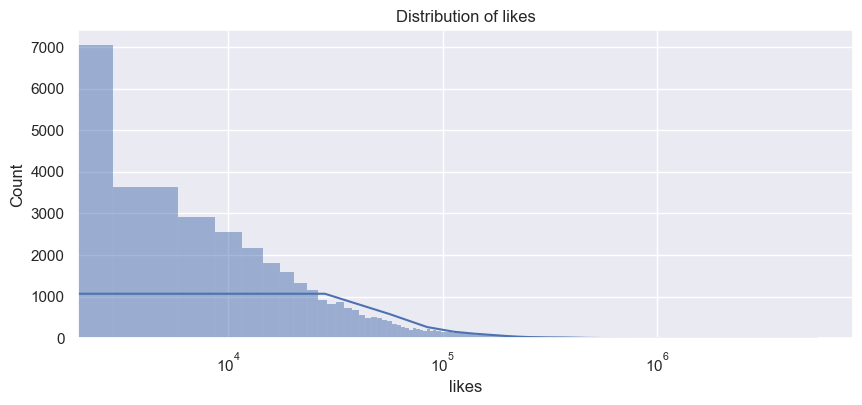

In [24]:
fig = plt.figure(figsize=(10, 4))
sns.histplot(df["likes"], kde=True)
plt.xscale("log")

plt.title("Distribution of likes")
plt.show()

The tail is very long (we saw that in the `describe()` as well), let's cut the top 5% and see the histogram again

In [25]:
percentile_95_likes = df["likes"].quantile(0.95)
df_filtered = df[(df["likes"] <= percentile_95_likes)]

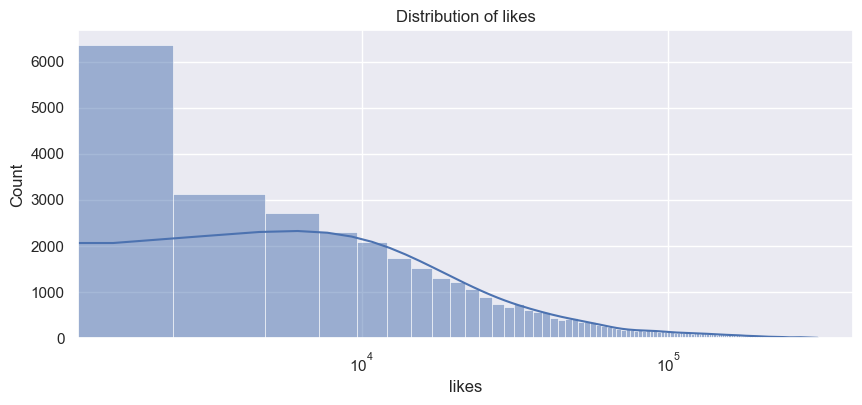

In [66]:
fig = plt.figure(figsize=(10, 4))
sns.histplot(df_filtered["likes"], kde=True)
plt.xscale("log")

plt.title("Distribution of likes")
plt.show()

## 1.2 Video Categories

In [27]:
df = df_filtered

Before we'll calculate the correlations between the numerical features and the target variable, we need to exclude the `category_id` feature, as it's a categorical feature.  
Let's load the categories names and merge them with the data

In [68]:
with open("youtube-new/US_category_id.json") as f:
    categories = json.load(f)

In [69]:
category_id_to_name = {int(category["id"]): category["snippet"]["title"] for category in categories["items"]}

In [70]:
df["category_name"] = df["category_id"].map(category_id_to_name)

In [73]:
df["category_name"].value_counts()

category_name
Entertainment            9672
Music                    5263
Howto & Style            4124
Comedy                   3352
People & Blogs           3124
News & Politics          2487
Science & Technology     2379
Film & Animation         2204
Sports                   2040
Education                1656
Pets & Animals            920
Gaming                    789
Travel & Events           402
Autos & Vehicles          384
Shows                      57
Nonprofits & Activism      48
Name: count, dtype: int64

We see that there are some categories with very few videos, let's aggregate them into a single category: `Other`

In [76]:
# Let's mark all the categories that have less than 500 videos as "Other"
categories_to_keep = df["category_name"].value_counts()[df["category_name"].value_counts() > 500].index
df.loc[~df["category_name"].isin(categories_to_keep), "category_name"] = "Other"

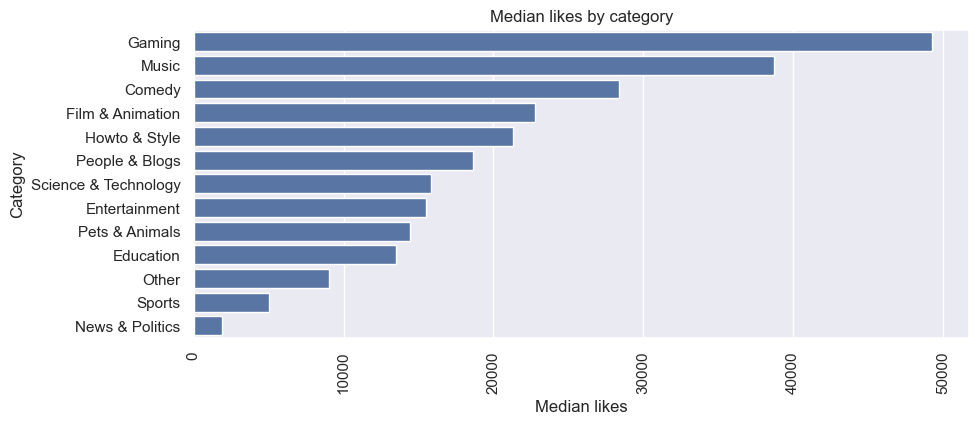

In [77]:
# Let's see the barplot of likes by category, sorted by the median
category_likes = df.groupby("category_name")["likes"].median().sort_values(ascending=False)
plt.figure(figsize=(10, 4))
sns.barplot(x=category_likes.values, y=category_likes.index)
plt.xlabel("Median likes")
plt.ylabel("Category")
plt.xticks(rotation=90)
plt.title("Median likes by category")
plt.show()

It seems like people like gaming videos the most, followed by music and comedy.  
Let's remove the `category_id` feature and calculate the correlations

In [74]:
df = df.drop(columns=["category_id"])

## 1.3 Correlations

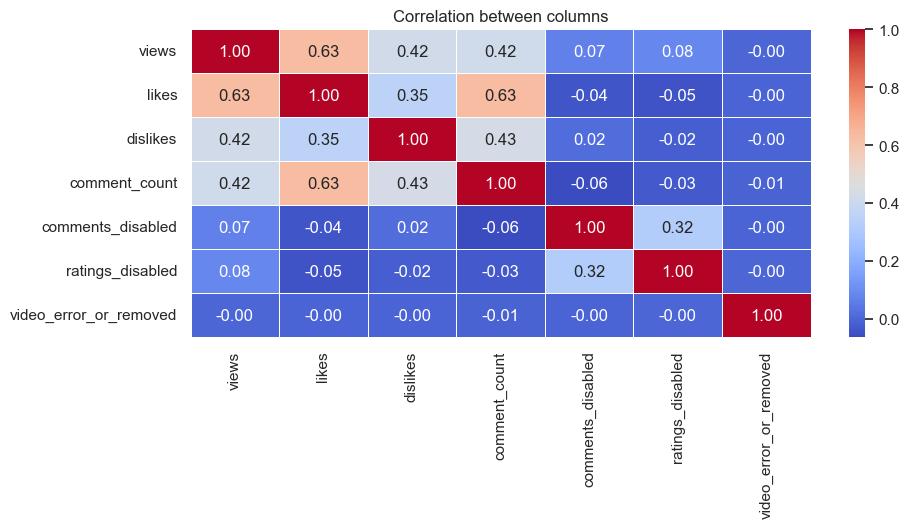

In [75]:
# See the correlation between the columns
plt.figure(figsize=(10, 4))
sns.heatmap(df.corr(numeric_only=True), annot=True, fmt=".2f", cmap="coolwarm", linewidths=0.5)
plt.title("Correlation between columns")
plt.show()

We can see from the heatmap that the `likes` are highly correlated with `views`, and `comment_count`. This is not surprising, as the more views a video has, the more likes and comments it will have.  
We can alse see that the `video_error_or_removed` feature has no correlation with the `likes` feature, so we'll take a deeper look at it

### 1.3.1 `video_error_or_removed` feature

In [78]:
df["video_error_or_removed"].value_counts()

video_error_or_removed
False    38879
True        22
Name: count, dtype: int64

In [84]:
df.groupby("video_error_or_removed")["likes"].mean()

video_error_or_removed
False    38441.503382
True     32420.863636
Name: likes, dtype: float64

There are only 22 videos with `video_error_or_removed` set to 1, with no significant difference in the `likes` feature.  
In order to avoid overfitting, we'll remove this feature from the data, and the rows with `video_error_or_removed` set to 1.

In [85]:
df = df[df["video_error_or_removed"] == False]
df = df.drop(columns=["video_error_or_removed"])

# 2. Feature Engineering

There are some features that we can create from the existing features, such as the `likes_per_view` and `likes_per_comment` features.  
Let's start with time manipulations features:

## 2.1 Time Features

We have 2 time features: `publish_time` and `trending_date`.  
Let's create the following features:
- `publish_hour`
- `publish_day`
- `publish_dayofweek`
- `publish_month`
- `publish_year`
- `trending_day`
- `trending_dayofweek`
- `trending_month`
- `trending_year`
- `days_to_trend`

In [101]:
df["publish_time"] = pd.to_datetime(df["publish_time"])
df["trending_date"] = pd.to_datetime(df["trending_date"], format="%y.%d.%m")

In [120]:
def split_date(dt: pd.Timestamp):
    return {
        "year": dt.year,
        "month": dt.month,
        "day": dt.day,
        "dayofweek": dt.dayofweek,
    }

splitted_publish_time = df.apply(
    lambda x: split_date(x["publish_time"]), axis=1, result_type="expand"
)
splitted_trending_date = df.apply(
    lambda x: split_date(x["trending_date"]), axis=1, result_type="expand"
)

splitted_publish_time = splitted_publish_time.add_prefix("publish_time_")
splitted_trending_date = splitted_trending_date.add_prefix("trending_date_")

df = pd.concat([df, splitted_publish_time, splitted_trending_date], axis=1)

In [125]:
plt.figure(figsize=(10, 6))
publish_hour_likes = df.groupby("publish_time_hour")["likes"].mean()
sns.lineplot(
    x=publish_hour_likes.index,
    y=publish_hour_likes.values,
    marker="o",
    color="green",
)
plt.title("Average Likes by Publish Hour", fontsize=16)
plt.xlabel("Publish Hour", fontsize=12)
plt.ylabel("Average Likes", fontsize=12)
plt.show()

KeyError: 'publish_time_hour'

<Figure size 1000x600 with 0 Axes>

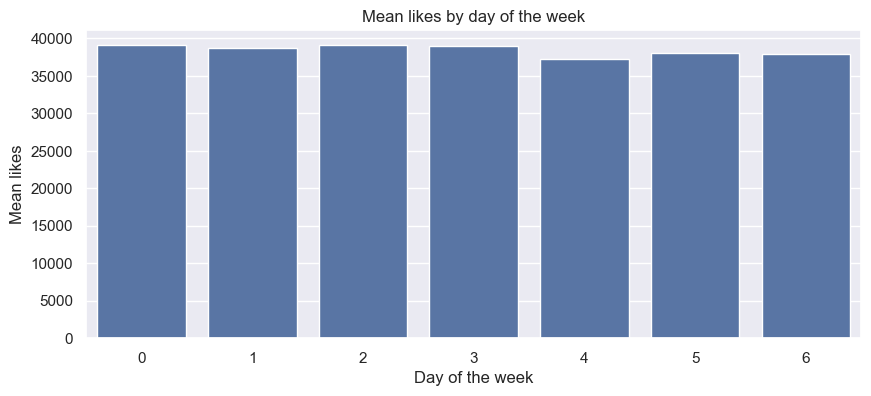

In [123]:
# Let's see the distribution of likes by day of the week
plt.figure(figsize=(10, 4))
sns.barplot(x=df.groupby("trending_date_dayofweek")["likes"].mean().index, y=df.groupby("trending_date_dayofweek")["likes"].mean().values)
plt.xlabel("Day of the week")
plt.ylabel("Mean likes")
plt.title("Mean likes by day of the week")

plt.show()